# Предсказание температуры

Необходимо предсказать температуру на каждый день в течение следующих 730 дней.
<br>Для выполнения необходио создать файл, в котором будет одна колонка `Temperature`, в которой содержатся 730 предсказаний.

### Импорт библиотек

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

Установка констант

In [64]:
#количество дней прогноза
PREDICTIONS = 730

## EDA

In [7]:
#чтение файла с распознаванием дат и установкой даты в индекс
df = pd.read_csv('temperature.csv', parse_dates=['Time'], index_col=['Time'])
df.info()
df.sample()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2010-01-01 to 2017-12-29
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2920 non-null   float64
dtypes: float64(1)
memory usage: 45.6 KB


,Temperature
Time,
2010-11-26,9.8


In [8]:
'количество уникальных значений температуры:', len(df['Temperature'].unique())

('количество уникальных значений температуры:', 219)

Распределение целевой переменной

In [9]:
df['Temperature'].describe()

count    2920.000000
mean       10.664144
std         3.927826
min         0.000000
25%         7.900000
50%        10.500000
75%        13.300000
max        26.000000
Name: Temperature, dtype: float64

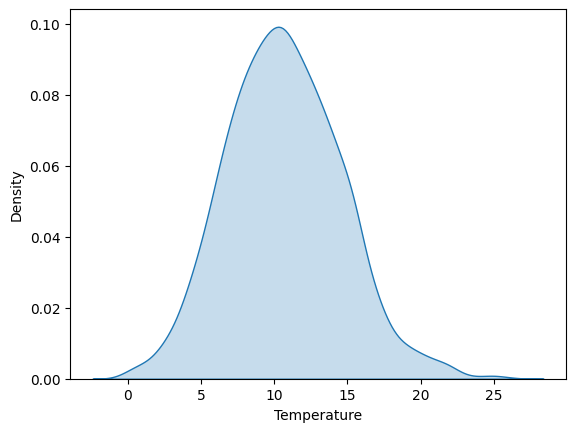

In [10]:
sns.kdeplot(df, x='Temperature', clip=(-10, 50), fill=True);

Вывод:
- медианное значение распределения практически равно среднему, можно сделать заключение о нормальности распределения, что подтверждается визуализацией

Распределение целевого признака по датам

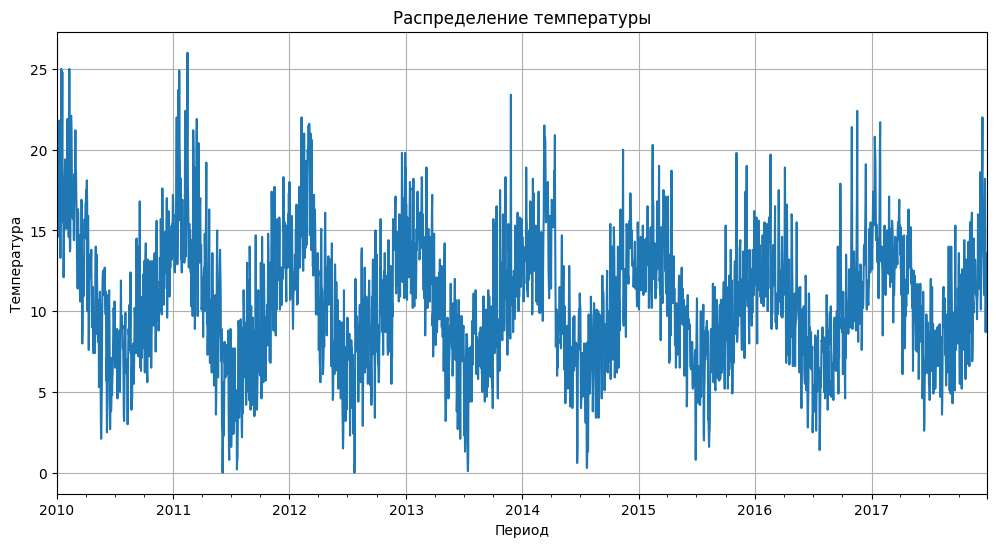

In [16]:
df['Temperature'].plot(figsize=(12,6));
plt.title("Распределение температуры")
plt.xlabel("Период")
plt.ylabel("Температура")
plt.grid();

Вывод:
- на графике явно прослеживается сезонность, что вполне логично

Посмотрим на средние температуры по месяцам

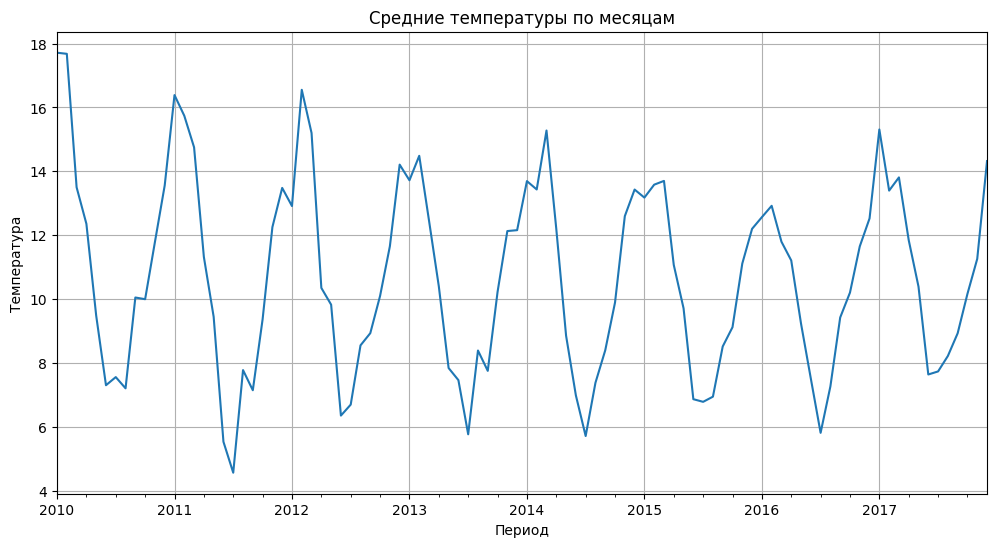

In [22]:
df_resample = df['Temperature'].resample('1M').mean()
df_resample.plot(figsize=(12,6))
plt.title("Средние температуры по месяцам")
plt.xlabel("Период")
plt.ylabel("Температура")
plt.grid();

Изучение сезонности, тренда и остатков

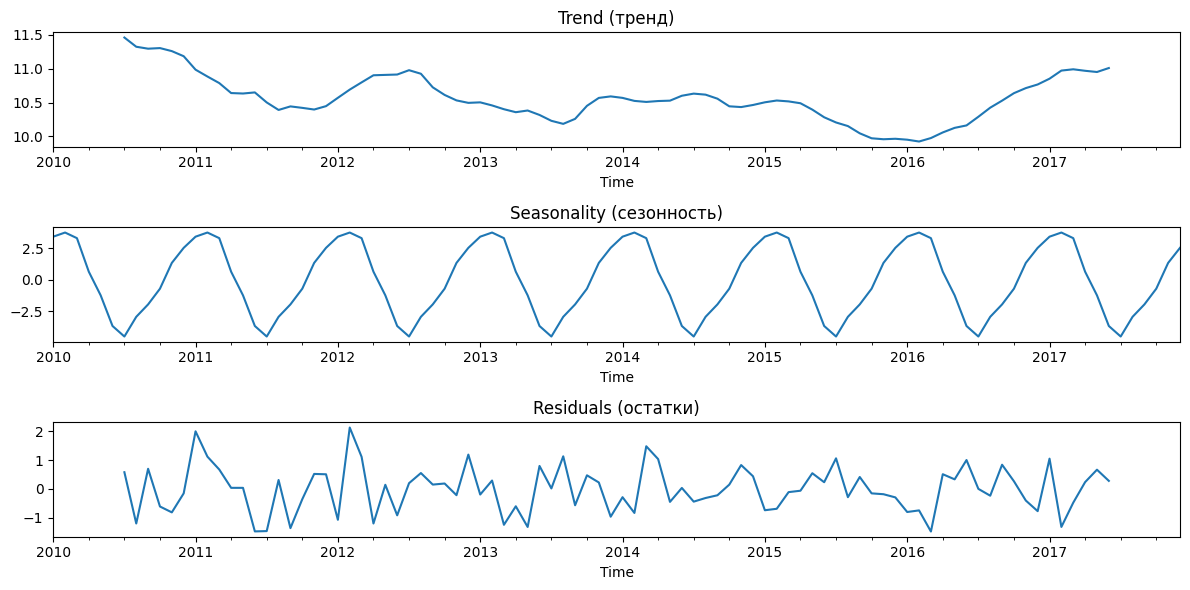

In [24]:
decomposed_units = seasonal_decompose(df_resample)

plt.figure(figsize=(12,6))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend (тренд)')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (сезонность)')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals (остатки)')
plt.tight_layout()

Вывод:
- наблюдается ярко выраженная сезонность
- явного тренда нет

Проверка на стационарность при помощи теста Дики-Фуллера

In [65]:
test = adfuller(df)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -4.249832163085375
p-value:  0.0005419750531920544
Critical values:  {'1%': -3.4326069302485953, '5%': -2.8625371602624137, '10%': -2.567300816765755}
единичных корней нет, можем предположить, что ряд стационарен


Вывод:
- проведённый тест Дики-Фуллера позволяет предположить стационарность ряда

## Обучение модели Prophet

Подготовка датафрейма

In [66]:
df_pr = df.reset_index().rename(columns={'Time': 'ds', 'Temperature': 'y'})
df_pr.sample(3)

,ds,y
823,2012-04-03,10.8
1592,2014-05-12,6.4
1060,2012-11-26,13.8


Данные для обучения

In [67]:
#из датафрейма вычтен период, равный прогнозируемому
X_train_pr = df_pr[:-PREDICTIONS]

Инициализация модели и её обучение

In [68]:
model_pr = Prophet(daily_seasonality=False, #дневная сезонность
                   weekly_seasonality=False, #недельная сезонность
                   yearly_seasonality=True) #годовая сезонность

model_pr.fit(X_train_pr)

21:09:45 - cmdstanpy - INFO - Chain [1] start processing
21:09:45 - cmdstanpy - INFO - Chain [1] done processing


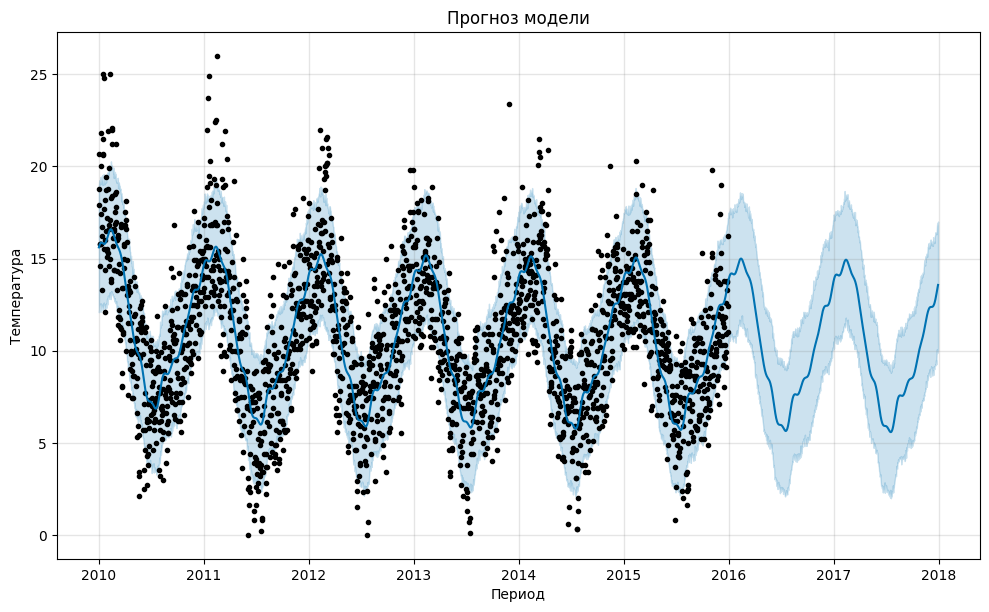

In [69]:
#получение предсказаний, отрисовка диаграммы
future = model_pr.make_future_dataframe(periods=PREDICTIONS)
forecast = model_pr.predict(future)
model_pr.plot(forecast)
plt.title("Прогноз модели")
plt.xlabel("Период")
plt.ylabel("Температура");

Вывод:
- чёрные точки - исходные данные,
- синяя линия - это модель прогноза,
- голубая область - доверительный интервал,
- по визуальному анализу можно сказать, что ошибки модели минимальны.

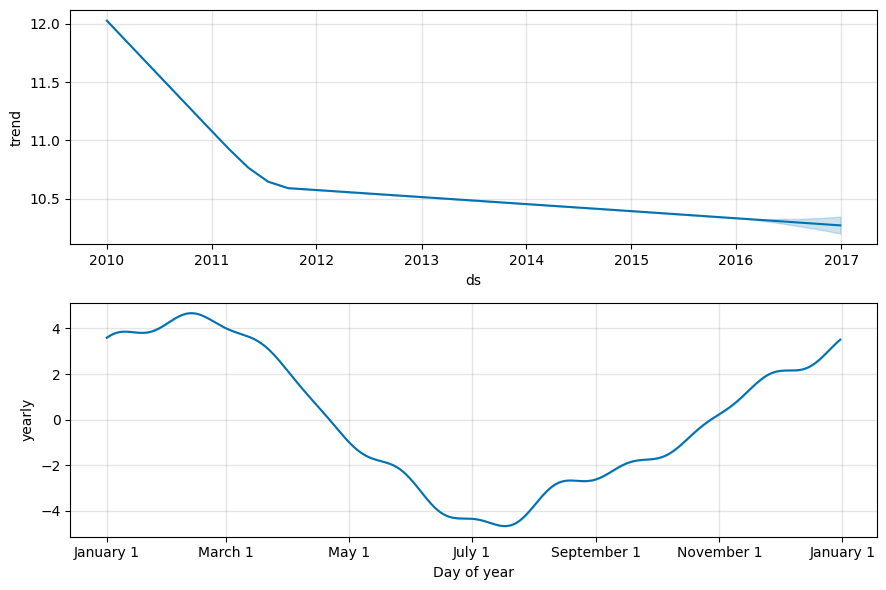

In [62]:
#сезонность
model_pr.plot_components(forecast);

Вывод:
- модель выявляет общий тренд и годовую сезонность

Проверка ошибок модели

In [74]:
df_forecast = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_pr.set_index('ds'))
df_forecast['mae'] = df_forecast['y'] - df_forecast['yhat']
df_forecast['mape'] = 100*df_forecast['mae']/df_forecast['y']
                                     
print('MAPE:', round(np.mean(abs(df_forecast[-PREDICTIONS:]['mape'])), 2), '%')
print('MAE:', round(np.mean(abs(df_forecast[-PREDICTIONS:]['mae'])), 2))

MAPE: 22.16 %
MAE: 2.11


Вывод:
- модель показывает довольно большое отклонение по `MAPE` = 22.16%
- в абсолютных значениях отклонения выглядят не так критично: `MAE` = 2.11